Daniele Sasso and a few others made their dataset availible on Zenodo - [https://doi.org/10.5281/zenodo.14927602](https://doi.org/10.5281/zenodo.14927602) - daily webscraped data from different shops of an Italian supermarket chain. This blog summarizes the dataset and explores its various facets. Detailed overview of the data is available on the [Price Stats Catalogue record of this dataset](https://un-task-team-for-scanner-data.github.io/price-stats-data-catalogue/italian-food-supermakets.html) and some explorations below are summarized there.

::: {.callout-tip}
## Reproduce this blog

This blog is a jupyter article under the hood - have a look at the source. Save a copy of the data to `/data/bronze/` and re-render.
:::

## Dataset structure

In [227]:
# Required libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from wordcloud import WordCloud

from itables import init_notebook_mode
from itables import show

import itables.options as opt

opt.maxBytes = 131072
opt.maxColumns = 0

init_notebook_mode(all_interactive=True)

## General overview of the dataset

First off - lets look at the data itself, its columns, and some statistics about the web scraping itself. 

In [228]:
# Load dataset
df = pd.read_csv("../data/bronze/Variations_Food_Prices_Italian_Supermarkets_raw.csv")

In [231]:
# df.head(15)
show(
    df, 
    buttons=["pageLength"],
    layout={"top1": "searchPanes"},
    searchPanes={"layout": "columns-2", "cascadePanes": True, "columns": [0, 2, 4,6]},
)

Loading ITables v2.5.2 from the init_notebook_mode cell... (need help?)


In [148]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4033211 entries, 0 to 4033210
Data columns (total 8 columns):
 #   Column      Dtype  
---  ------      -----  
 0   date        object 
 1   price       float64
 2   product_id  int64  
 3   store_id    int64  
 4   region      object 
 5   product     object 
 6   COICOP5     object 
 7   COICOP4     object 
dtypes: float64(1), int64(2), object(5)
memory usage: 246.2+ MB


## Detailed info about the dataset

As this is web scrape data for several years - its saved all in one analytical table. 

Let's look at it in a bit more detail:

In [233]:
#| echo: true
#| code-fold: true

stats = {}
stats['Number of unique products'] = df['product'].nunique()
stats['Number of unique stores'] = df['store_id'].nunique()
stats['Number of unique regions'] = df['region'].nunique()
stats['Number of COICOP5 categories'] = df['COICOP5'].nunique()
stats['Number of unique scrapes'] = df['date'].nunique()
stats['Number of average unique products per store per date'] = round(df.groupby(["date", "store_id"])["product_id"].nunique().reset_index()['product_id'].mean(),1)
d_end = datetime.fromisoformat(df['date'].max())
d_start = datetime.fromisoformat(df['date'].min())
d = d_end-d_start
stats['number of days in sample'] = d.days + 1
pd.DataFrame.from_dict(stats, orient='index', columns=['statistic'])

Loading ITables v2.5.2 from the init_notebook_mode cell... (need help?)


It seems that there are 863 days but 841 scrapes - that means that there were no scrapes during 22 days:

In [234]:
#| echo: true
#| code-fold: true

# Compare the current scrape list
scrape_dates = pd.DatetimeIndex(df['date'].unique())

# Against an uninterupted list of dates
start_date = scrape_dates.min()
end_date = scrape_dates.max()

# Create a complete, continuous date range
full_date_range = pd.date_range(start=start_date, end=end_date, freq='D')

# Find the dates that are in the full range but not in the scrape list
missing_dates = full_date_range.difference(scrape_dates)
# missing_dates

missing_dates

DatetimeIndex(['2021-02-13', '2021-02-14', '2021-03-23', '2021-03-28',
               '2021-06-24', '2021-08-22', '2021-08-23', '2021-08-24',
               '2021-08-25', '2021-08-26', '2021-08-27', '2021-09-30',
               '2021-12-02', '2022-01-23', '2022-03-16', '2022-06-21',
               '2022-10-01', '2022-10-07', '2022-10-10', '2022-10-22',
               '2022-10-23', '2022-11-04'],
              dtype='datetime64[ns]', freq=None)

If we pivot the raw data and show the number of prices captured per store per region - it looks like this:

In [235]:
#| echo: true
#| code-fold: true

df.pivot_table(index='date', columns=['region','store_id'], aggfunc='count')

Loading ITables v2.5.2 from the init_notebook_mode cell... (need help?)


Lets also look at the number of stores per region (i.e. the above but visually)

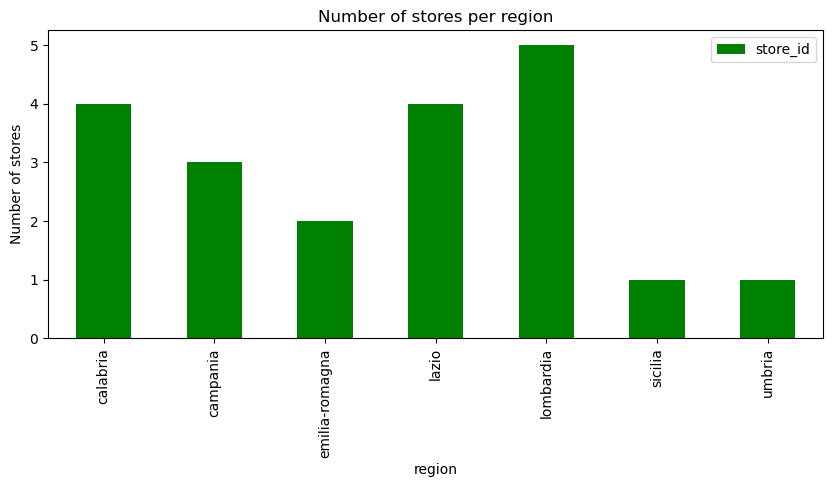

In [225]:
#| echo: true
#| code-fold: true

df_number_of_stores_per_region = df.groupby(["region"])["store_id"].nunique().to_frame()
df_number_of_stores_per_region.plot(kind='bar', color='green', figsize=(10,4))
plt.title('Number of stores per region')
plt.xlabel('region')
plt.ylabel('Number of stores')
# plt.xticks(rotation=1)  # Keep x-axis labels horizontal
plt.show()

## Trends about what was captured

### By category

Lets look at the number of unique products and the number of web offers captured by COICOP5 category

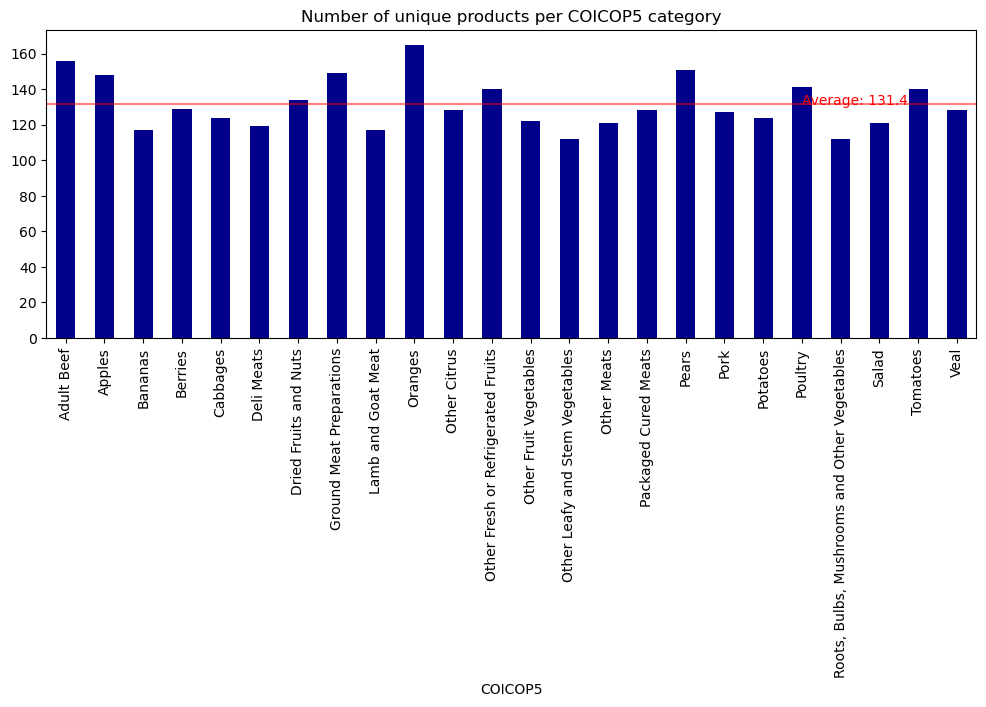

In [223]:
#| echo: true
#| code-fold: true

df_coicop_categories = df.groupby(["COICOP5"])["product_id"].nunique()
mean = df_coicop_categories.mean()

fix, ax = plt.subplots()

df_coicop_categories.plot(
    kind="bar",
    figsize=(12,4),
    title="Number of unique products per COICOP5 category",
    color='darkblue',
    legend=False,
    ax=ax
)

ax.axhline(mean, color='red', alpha=0.5)

ax.text(
    x=19,
    y=mean,
    s=f'Average: {round(mean,1)}',
    color='red',
)

plt.show()


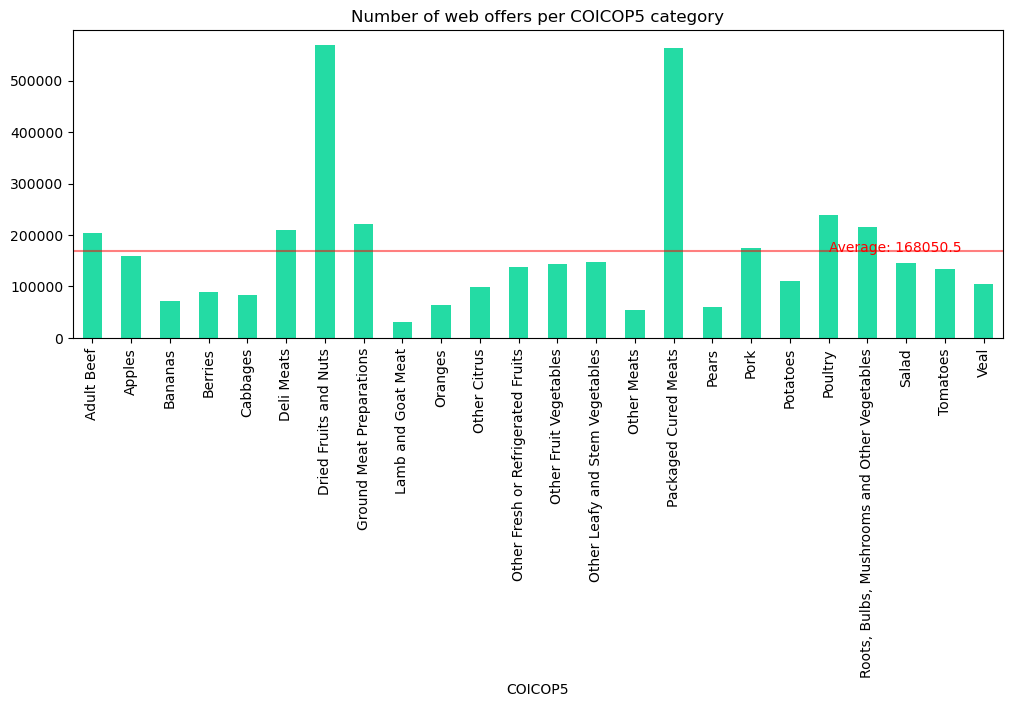

In [224]:
#| echo: true
#| code-fold: true

df_coicop_categories = df.groupby(["COICOP5"])["product_id"].count()
mean = df_coicop_categories.mean()

fix, ax = plt.subplots()

df_coicop_categories.plot(
    kind="bar",
    figsize=(12,4),
    title="Number of web offers per COICOP5 category",
    color="#24dba4",
    legend=False,
    ax=ax
)

ax.axhline(mean, color='red', alpha=0.5)

ax.text(
    x=19,
    y=mean,
    s=f'Average: {round(mean,1)}',
    color='red',
)

plt.show()

### Over time

We can also consider how much data was captured across time

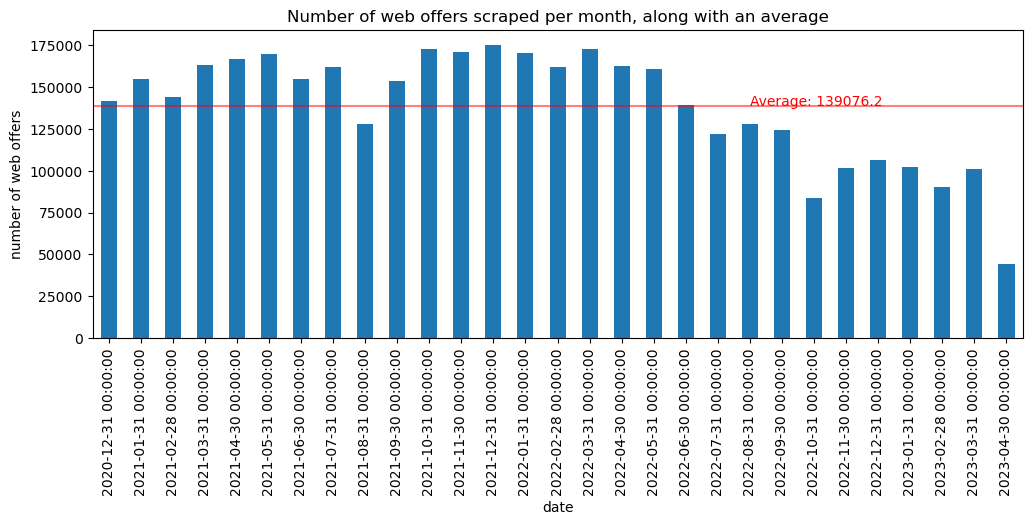

In [226]:
#| echo: true
#| code-fold: true

df2 = df.copy(deep=True)
df2['date'] = pd.to_datetime(df2['date'])
df2 = df2.set_index('date')
df_scrapes = df2.resample('ME')['product_id'].count().to_frame()
scrape_mean_monthly = df_scrapes['product_id'].mean()

fix, ax = plt.subplots()

df_scrapes.plot(
    kind='bar',
    figsize=(12,4),
    title="Number of web offers scraped per month, along with an average",
    legend=False,
    ax=ax)
plt.ylabel("number of web offers")

ax.axhline(scrape_mean_monthly, color='red', alpha=0.5, label="average")

ax.text(
    x=20,
    y=scrape_mean_monthly,
    s=f'Average: {round(scrape_mean_monthly,1)}',
    color='red',
)

plt.show()


It seems that the amount of web offers started to decline. This should probably be investigated (if its region or store coverage) to see if longitudinal time series should exclude any of this data

# Price and Product analysis

## Geographic distribution of unique products by region

There is some example code in [the zenodo page for the dataset](https://zenodo.org/records/14927602) that shows well some of the price/product info captured

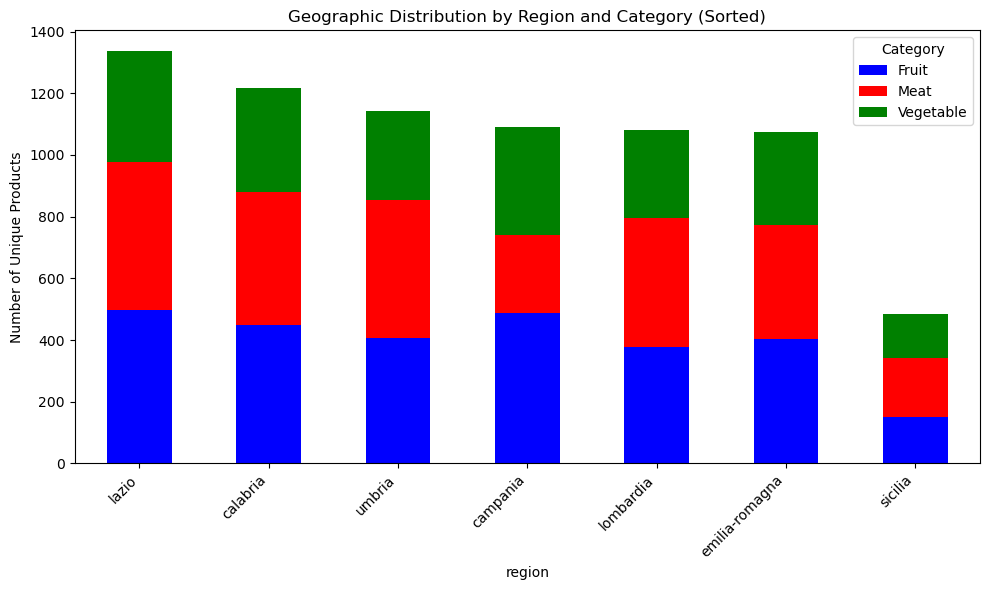

In [149]:
#| echo: true
#| code-fold: true

# Convert date column
df['date'] = pd.to_datetime(df['date'])  # Format: YYYY-MM-DD

# Define category colors
category_colors = {"Fruit": "blue", "Vegetable": "green", "Meat": "red"}

geo = df.groupby(["region", "COICOP4"])["product_id"].nunique().reset_index()
pivot_geo = geo.pivot(index="region", columns="COICOP4", values="product_id").fillna(0)
pivot_geo["Total"] = pivot_geo.sum(axis=1)
pivot_geo = pivot_geo.sort_values("Total", ascending=False).drop(columns="Total")
pivot_geo = pivot_geo[["Fruit", "Meat", "Vegetable"]]

pivot_geo.plot(kind="bar", stacked=True, figsize=(10,6), color=["blue", "red", "green"])
plt.ylabel("Number of Unique Products")
plt.title("Geographic Distribution by Region and Category (Sorted)")
plt.xticks(rotation=45, ha="right")
plt.legend(title="Category")
plt.tight_layout()
plt.show()

## Basic analysis: average price trend over time (by COICOP4)

We can also look at average prices by COICOP4 over time

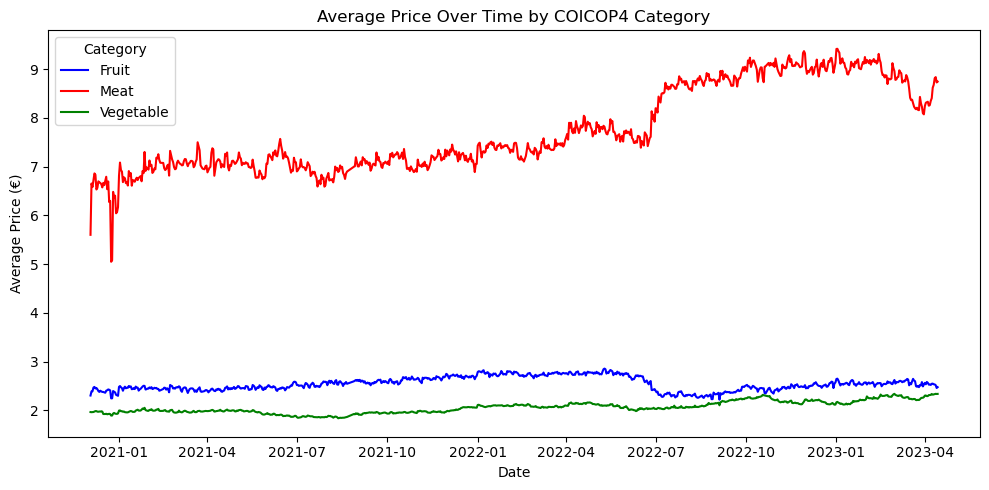

In [151]:
#| echo: true
#| code-fold: true

price_trend = df.groupby(["date", "COICOP4"])["price"].mean().reset_index()

plt.figure(figsize=(10,5))
sns.lineplot(data=price_trend, x="date", y="price", hue="COICOP4", palette=category_colors)
plt.title("Average Price Over Time by COICOP4 Category")
plt.xlabel("Date")
plt.ylabel("Average Price (€)")
plt.legend(title="Category")
plt.tight_layout()
plt.show()

In [220]:
# WIP ... create wordclouds per COICOP5 category to see what types of products are in each


# df_products_by_category = df["COICOP5, product_id"].drop_duplicates(subset=["COICOP5, product_id"])
# df_products_by_category

df_products_by_category = df[["COICOP5", "product"]].drop_duplicates()
for category in df_products_by_category['COICOP5'].drop_duplicates():
    # print(category)
    break

# row_condition = df_products_by_category['COICOP5']==category

# products_from_category = df_products_by_category.loc(row_condition, 'product')

# text = ... concat all products, potentially drop units of measure (if they crowd out the wordcloud)

# # Create a WordCloud object
# wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# # Display the generated image
# plt.figure(figsize=(10, 5))
# plt.imshow(wordcloud, interpolation='bilinear')
# plt.axis('off')  # Hide the axes
# plt.show()